<a href="https://colab.research.google.com/github/AUT-Student/BigData-HW2/blob/main/BigData_HW2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySpark Setting

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 25 kB/s 
     |████████████████████████████████| 198 kB 10.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=70b7bbbf9b33924338929fa322dae44a9f553492ea8c22a3ee4e71ff965ab819
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
spark

# Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql import Window

# Dataset

In [7]:
!gdown 1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
!unzip /content/Bigdata_hw2_datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
To: /content/Bigdata_hw2_datasets.zip
100% 6.28M/6.28M [00:00<00:00, 46.8MB/s]
Archive:  /content/Bigdata_hw2_datasets.zip
   creating: Bigdata_hw2_datasets/
   creating: Bigdata_hw2_datasets/q1/
  inflating: Bigdata_hw2_datasets/q1/stream_data_dgim.txt  
   creating: Bigdata_hw2_datasets/q2/
  inflating: Bigdata_hw2_datasets/q2/games.csv  
  inflating: Bigdata_hw2_datasets/q2/ratings.csv  
   creating: Bigdata_hw2_datasets/q3/
  inflating: Bigdata_hw2_datasets/q3/c1.txt  
  inflating: Bigdata_hw2_datasets/q3/c2.txt  
  inflating: Bigdata_hw2_datasets/q3/data.txt  


In [8]:
dataset_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/data.txt", header=None, names=["data"])
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda x:x.split(" "))
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda item: [float(x) for x in item])
dataset_pandas["data-id"] = range(len(dataset_pandas))

c1_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c1.txt", header=None, names=["center"])
c1_pandas["center"] = c1_pandas["center"].apply(lambda x:x.split(" "))
c1_pandas["center"] = c1_pandas["center"].apply(lambda item: [float(x) for x in item])
c1_pandas["center-id"] = range(len(c1_pandas))

c2_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c2.txt", header=None, names=["center"])
c2_pandas["center"] = c2_pandas["center"].apply(lambda x:x.split(" "))
c2_pandas["center"] = c2_pandas["center"].apply(lambda item: [float(x) for x in item])
c2_pandas["center-id"] = range(len(c2_pandas))

In [9]:
NUMBER_FEATURES = 58

# KMeans

In [28]:
class SparkKMeans():
  def __init__(self, dataset, center, description):
    self.dataset_spark = spark.createDataFrame(dataset)
    self.center_spark = spark.createDataFrame(center)
    self.description = description

  def run(self, number_epochs):
    self.number_epochs = number_epochs
    self.costs = []
    for step in range(number_epochs):
      data_center_spark = self.dataset_spark.join(self.center_spark)\
                              .withColumn('distance', self.euclidean_distance(self.dataset_spark.data, self.center_spark.center))

      data_center_spark = data_center_spark.withColumn("min-distance", f.min("distance")\
                                           .over(Window.partitionBy("data-id")))\
                                           .where(f.col("min-distance") == f.col("distance"))\
                                           .drop(*["min-distance", "center"])

      step_cost = data_center_spark.select("distance")\
                                   .groupBy().sum().collect()[0][0]
      
      self.costs.append(step_cost)
      print(f"Step = {step}, Cost = {step_cost}")

      data_center_mapping = data_center_spark.drop(*["data", "distance"])\
                                             .toDF("data-id", "center-id")\
                                             .toPandas()
      
      data_center_spark = data_center_spark.groupBy("center-id")\
                                           .agg(f.collect_list("data")\
                                           .alias("data-list"))

      array_mean_udf = udf(self.array_mean, ArrayType(FloatType()))

      self.center_spark = data_center_spark.select("center-id", array_mean_udf("data-list")\
                                           .alias("center"))

    return data_center_mapping

  def report(self):
    print(f"Change cost percent in ten steps {int((self.costs[0] - self.costs[10]) / self.costs[0] * 100)}%\n") 

    plt.scatter(range(1, self.number_epochs+1), self.costs)
    plt.plot(range(1, self.number_epochs+1), self.costs)
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.title(f"Change Cost in KMeans\n{self.description}")
    plt.show()

  @staticmethod
  def euclidean_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += (a[i] - b[i]) ** 2
    return distance ** 0.5

  @staticmethod
  def array_mean(x):
    number_data = len([i for i in zip(*x)][0])
    sum_array = [sum(i) for i in zip(*x)]
    return [item/number_data for item in sum_array]

In [29]:
kmeans = SparkKMeans(dataset=dataset_pandas, center=c1_pandas, description="C1-Euclidean")

In [ ]:
kmeans_output = kmeans.run(number_epochs=15)

Step = 0, Cost = 395749.8468388532
Step = 1, Cost = 318949.51101113483
Step = 2, Cost = 316897.8071501825
Step = 3, Cost = 327978.22519918176
Step = 4, Cost = 333528.0769713639


Change cost percent 0.1992471767671429


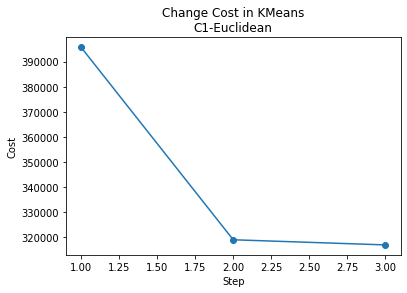

In [27]:
kmeans.report()